# Predicting Airline Data using a Generalized Linear Model (GLM) in Keras

In particular, we will predict the probability that a flight is late based on its departure date/time, the expected flight time and distance, the origin and destitation airports.

Most part of this notebooks are identical to what has been done in Airline Delay with a GLM in python3.ipynb
The main difference is that we will use the [Keras](https://keras.io/) high-level library with a tensorflow backend (theano backend is also available) to perform the machine learning operations instead of scikit-learn.

The core library for the dataframe part is [pandas](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html).<br>
The core library for the machine learning part is [Keras](https://keras.io/).  This library is mostly used for deeplearning/neural-network machine learning, but it can also be used to implement most of Generalized Linear Models.  It is also quite easy to add new types of model layers into the Keras API if new functionalities would be needed.

The other main advantage of Keras is that it a high level API on top of either tensorflow/theano.  Writting new complex model is in Keras is much more simple than in tensorflow/theano.  But keep the benefits of these low-level library for what concerns the computing performances on CPU/GPU.

### Considerations

The objective of this notebook is to define a simple model offerring a point of comparison in terms of computing performances across datascience language and libraries.  In otherwords, this notebook is not for you if you are looking for the most accurate model in airline predictions.  

## Install and Load useful libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

## Load the data (identical to python3 scikit-learn)

- The dataset is taken from [http://stat-computing.org](http://stat-computing.org/dataexpo/2009/the-data.html).  We take the data corresponding to year 2008.
- We restrict the dataset to the first million rows
- We print all column names and the first 5 rows of the dataset

In [2]:
df = pd.read_csv("2008.csv")
df.shape[0]

7009728

In [3]:
df = df[0:1000000]

In [4]:
df.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [5]:
df[0:5]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


## Data preparation for training (identical to python3 scikit-learn)

- We turn origin/destination categorical data to a "one-hot" encoding representation
- We create a new "binary" column indicating if the flight was delayed or not.
- We show the first 5 rows of the modified dataset
- We split the dataset in two parts:  a training dataset and a testing dataset containing 80% and 20% of the rows, respectively.

In [6]:
df = pd.concat([df, pd.get_dummies(df["Origin"], prefix="Origin")], axis=1);
df = pd.concat([df, pd.get_dummies(df["Dest"  ], prefix="Dest"  )], axis=1);
df = df.dropna(subset=["ArrDelay"]) 
df["IsArrDelayed" ] = (df["ArrDelay"]>0).astype(int)
df[0:5]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,Dest_TYR,Dest_TYS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM,IsArrDelayed
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,0,0,0,0,0,0,0,0,0,0
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,0,0,0,0,0,0,0,0,0,1
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,0,0,0,0,0,0,0,0,0,1
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,0,0,0,0,0,0,0,0,0,0
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,0,0,0,0,0,0,0,0,0,1


In [7]:
train = df.sample(frac=0.8)
test  = df.drop(train.index)

## Model building

- We define the generalized linear model using a binomial function --> Logistic regression.
   - The model has linear logits = (X*W)+B = (Features * Coefficients) + Bias
   - The Loss function is a logistic function (binary_cross_entropy)
   - A L2 regularization is added to mimic what is done in scikit learn
   - Specific callbacks are defined (one for logging and one for early stopping the training)
- We train the model and measure the training time --> ~55sec on an intel i7-6700K (4.0 GHz) with a GTX970 4GB GPU for 800K rows 
   - The model is trained using a minibatch strategy (that can be tune for further performance increase)
- We show the model coefficients
- We show the 10 most important variables

In [8]:
#get the list of one hot encoding columns
OriginFeatCols = [col for col in df.columns if ("Origin_" in col)]
DestFeatCols   = [col for col in df.columns if ("Dest_"   in col)]
features = train[["Year","Month",  "DayofMonth" ,"DayOfWeek", "DepTime", "AirTime", "Distance"] + OriginFeatCols + DestFeatCols  ]
labels   = train["IsArrDelayed"]
featuresMatrix = features.as_matrix()
labelsMatrix   = labels  .as_matrix().reshape(-1,1)

In [49]:
featureSize     = features.shape[1]
labelSize       = 1
training_epochs = 25
batch_size      = 2500

from keras.models import Sequential 
from keras.layers import Dense, Activation 
from keras.regularizers import l2, activity_l2
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping

#DEFINE A CUSTOM CALLBACK
class IntervalEvaluation(Callback):
    def __init__(self): super(Callback, self).__init__()
    def on_epoch_end(self, epoch, logs={}): print("interval evaluation - epoch: %03d - loss:%8.6f" % (epoch, logs['loss']))

#DEFINE AN EARLY STOPPING FOR THE MODEL
earlyStopping = EarlyStopping(monitor='loss', patience=1, verbose=0, mode='auto')
        
#DEFINE THE MODEL
model = Sequential() 
model.add(Dense(labelSize, input_dim=featureSize, activation='sigmoid', W_regularizer=l2(1e-5))) 
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy']) 

#FIT THE MODEL
model.fit(featuresMatrix, labelsMatrix, batch_size=batch_size, nb_epoch=training_epochs,verbose=0,callbacks=[IntervalEvaluation(),earlyStopping]);

interval evaluation - epoch: 000 - loss:7.908120
interval evaluation - epoch: 001 - loss:0.709510
interval evaluation - epoch: 002 - loss:0.645070
interval evaluation - epoch: 003 - loss:0.643035
interval evaluation - epoch: 004 - loss:0.640767
interval evaluation - epoch: 005 - loss:0.638643
interval evaluation - epoch: 006 - loss:0.639472
interval evaluation - epoch: 007 - loss:0.638968


In [50]:
coef = pd.DataFrame(data=model.layers[0].get_weights()[0], index=features.columns, columns=["Coef"])
coef = coef.reindex( coef["Coef"].abs().sort_values(axis=0,ascending=False).index )  #order by absolute coefficient magnitude
coef[ coef["Coef"].abs()>0 ] #keep only non-null coefficients
coef[ 0:10 ] #keep only the 10 most important coefficients

,Coef
Origin_JFK,-1.115764
Dest_SJU,1.098557
Origin_SFO,1.040743
Origin_ISP,-1.035402
Dest_CPR,-0.951190
Origin_MHT,-0.911953
Origin_PVD,-0.901687
Origin_BOS,-0.897174
Origin_DCA,-0.895218
Dest_LIH,-0.890239


## Model testing (identical to python3 scikit-learn)

- We add a model prediction column to the testing dataset
- We show the first 10 rows of the test dataset (with the new column)
- We show the model ROC curve
- We measure the model Area Under Curve (AUC) to be 0.689 on the testing dataset.  

This is telling us that our model is not super accurate  (we generally assume that a model is raisonable at predicting when it has an AUC above 0.8).  But, since we are not trying to build the best possible model, but just show comparison of data science code/performance accross languages/libraries.
If none the less you are willing to improve this result, you should try adding more feature column into the model.

In [51]:
testFeature = test[["Year","Month",  "DayofMonth" ,"DayOfWeek", "DepTime", "AirTime", "Distance"] + OriginFeatCols + DestFeatCols  ]
pred = model.predict( testFeature.as_matrix() )
test["IsArrDelayedPred"] = pred
test[0:10]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,Dest_TYS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM,IsArrDelayed,IsArrDelayedPred
5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,...,0,0,0,0,0,0,0,0,1,0.544917
15,2008,1,3,4,1029.0,1020,1021.0,1010,WN,2272,...,0,0,0,0,0,0,0,0,1,0.450467
16,2008,1,3,4,1452.0,1425,1640.0,1625,WN,675,...,0,0,0,0,0,0,0,0,1,0.674264
17,2008,1,3,4,754.0,745,940.0,955,WN,1144,...,0,0,0,0,0,0,0,0,0,0.455986
21,2008,1,3,4,1657.0,1625,1754.0,1735,WN,623,...,0,0,0,0,0,0,0,0,1,0.467789
22,2008,1,3,4,1900.0,1840,1956.0,1950,WN,717,...,0,0,0,0,0,0,0,0,1,0.536091
29,2008,1,3,4,734.0,730,958.0,1020,WN,550,...,0,0,0,0,0,0,0,0,0,0.489043
34,2008,1,3,4,1449.0,1430,1715.0,1720,WN,3398,...,0,0,0,0,0,0,0,0,0,0.421931
38,2008,1,3,4,1127.0,1105,1235.0,1230,WN,1837,...,0,0,0,0,0,0,0,0,1,0.361423
46,2008,1,3,4,634.0,635,907.0,935,WN,3928,...,0,0,0,0,0,0,0,0,0,0.274017


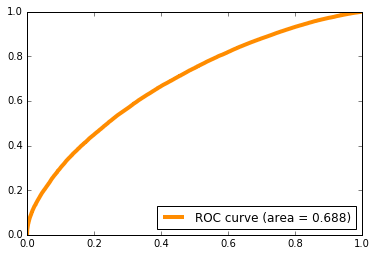

In [52]:
fpr, tpr, _ = roc_curve(test["IsArrDelayed"], test["IsArrDelayedPred"])
AUC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=4, label='ROC curve (area = %0.3f)' % AUC)
plt.legend(loc=4)

In [53]:
AUC

0.68847595515112259

## Key takeaways

- We built a GLM model predicting airline delay probability in tensorflow
- We train it on 800K rows in ~55sec on an intel i7-6700K (4.0 GHz) with a GTX970 GPU
- We measure an AUC of 0.689, which is almost identical to python-3 scikit learn results
- We demonstrated a typical workflow in python+keras in a Jupyter notebook
- We can easilly customize the model using the several type of layers available in Keras.  That would make our model much more accurarte and sophisticated with no additional pain in either complexity or computing performance.

[Keras](https://keras.io/) documentation is quite complete and contains several examples from linear algebra to advance deep learning techniques.